```
This software is part of GPU Ocean. 

Copyright (C) 2017-2023 SINTEF Digital
Copyright (C) 2017-2023 Norwegian Meteorological Institute

This notebooks shows Monte Carlo realisations of the doublejet example

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Double Jet

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

In [2]:
from gpuocean.utils import Common, IPythonMagic

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
from gpuocean.utils import DoubleJetCase

doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, model_error=2, ny=256, nx=512)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

In [5]:
sim_model_error_basis_args = {
                            "basis_x_start": 2, 
                            "basis_x_end": 8,
                            "basis_y_start": 1,
                            "basis_y_end": 7,

                            "kl_decay": 1.25,
                            "kl_scaling": 0.01,
                            }

In [6]:
from gpuocean.ensembles import OceanModelEnsemble
from gpuocean.utils import Observation

In [7]:
doubleJetCase_args.pop("gpu_ctx")

In [8]:
import copy
data_args = copy.deepcopy(doubleJetCase_args)
data_args.update(doubleJetCase_init)

In [9]:
ensemble = OceanModelEnsemble.OceanModelEnsemble(gpu_ctx, 
                                                 {},
                                                 data_args, 
                                                 sim_model_error_basis_args,
                                                 25)

In [10]:
dim_x = doubleJetCase_args["dx"]*doubleJetCase_args["nx"]
dim_y = doubleJetCase_args["dy"]*doubleJetCase_args["ny"]

In [11]:
def stepToObservation(ensemble, observation_time, progress_info=True, obs_dt=300):
    """
    Advance the ensemble to the given observation time, and mimics CDKLM16.dataAssimilationStep function
    
    Arguments:
        observation_time: The end time for the simulation 
    """
    ensemble_obs = []
    for p in range(ensemble.getNumParticles()):

        if ensemble.particles[p].hasDrifters:

            observation_args = {
                'nx': ensemble.particles[p].nx, 'ny': ensemble.particles[p].ny,
                'domain_size_x': ensemble.particles[p].nx*ensemble.particles[p].dx,
                'domain_size_y': ensemble.particles[p].ny*ensemble.particles[p].dy,
                'land_mask': ensemble.particles[p].getLandMask()
               }

            obs = Observation.Observation(**observation_args)
            ensemble_obs.append(obs)
            obs.add_observation_from_sim(ensemble.particles[p])
    
        # Only active particles are evolved
        while ensemble.particles[p].t < observation_time - 0.001:
            ensemble.particles[p].dataAssimilationStep(np.minimum(ensemble.particles[p].t+obs_dt,observation_time))
            if ensemble.particles[p].hasDrifters:
                obs.add_observation_from_sim(ensemble.particles[p])

        if progress_info:
            print('Step done for particle ' + str(p))
        
    ensemble.t = observation_time

    return ensemble_obs

In [12]:
Y = np.arange(start=doubleJetCase_args["dy"]/2, stop=doubleJetCase_args["dy"]*(doubleJetCase_args["ny"]+0.5), step=doubleJetCase_args["dy"])/1000

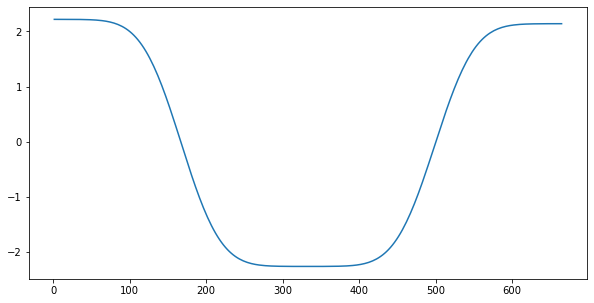

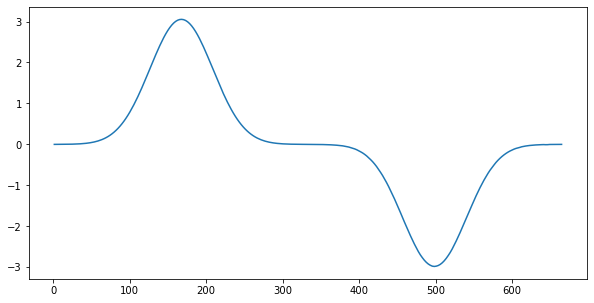

In [13]:
plt.figure(figsize=(10,5))
plt.plot(Y, doubleJetCase_init["eta0"][2:-2,0])

plt.figure(figsize=(10,5))
u = doubleJetCase_init["hu0"][2:-2,0]/(doubleJetCase_args["H"][0][0] + doubleJetCase_init["eta0"][2:-2,0])
plt.plot(Y, u)

In [14]:
# np.savetxt("eta0.txt", np.c_[Y, doubleJetCase_init["eta0"][2:-2,0]], delimiter=",")
# np.savetxt("u0.txt", np.c_[Y, u], delimiter=",")

In [15]:
ensemble_obs = stepToObservation(ensemble, 7*24*3600)

Step done for particle 0
Step done for particle 1
Step done for particle 2
Step done for particle 3
Step done for particle 4
Step done for particle 5
Step done for particle 6
Step done for particle 7
Step done for particle 8
Step done for particle 9
Step done for particle 10
Step done for particle 11
Step done for particle 12
Step done for particle 13
Step done for particle 14
Step done for particle 15
Step done for particle 16
Step done for particle 17
Step done for particle 18
Step done for particle 19
Step done for particle 20
Step done for particle 21
Step done for particle 22
Step done for particle 23
Step done for particle 24


In [16]:
# mean_eta, mean_hu, mean_hv = np.zeros((3, 256, 512))
# for e in range(ensemble.numParticles):
#     tmp_eta, tmp_hu, tmp_hv = ensemble.particles[e].download(interior_domain_only=True)
#     mean_eta += 1/ensemble.numParticles * tmp_eta
#     mean_hu += 1/ensemble.numParticles * tmp_hu
#     mean_hv += 1/ensemble.numParticles * tmp_hv

# np.save("figs/mean.npy", np.array([mean_eta, mean_hu, mean_hv]))

In [17]:
mean_eta, mean_hu, mean_hv = np.load("figs/mean500.npy")

In [18]:
extent = [0, doubleJetCase_args["dx"]*doubleJetCase_args["nx"]/1000, 0, doubleJetCase_args["dy"]*doubleJetCase_args["ny"]/1000]

In [19]:
H = doubleJetCase_args["H"][0][0]

def Vplot(eta, hu, hv, filename):

    plt.figure(figsize=(10,5))
    u = hu/(H + eta)
    v = hv/(H + eta)

    V = np.sqrt(u**2 + v**2)

    extent = [0, doubleJetCase_args["dx"]*doubleJetCase_args["nx"]/1000, 0, doubleJetCase_args["dy"]*doubleJetCase_args["ny"]/1000]

    plt.imshow(V, extent=extent, cmap=plt.cm.Oranges, vmin=0.0, vmax=5, origin="lower")

    x = np.arange(doubleJetCase_args["dx"]/2, (doubleJetCase_args["nx"]+0.5)*doubleJetCase_args["dx"], doubleJetCase_args["dx"])/1000
    y = np.arange(doubleJetCase_args["dy"]/2, (doubleJetCase_args["ny"]+0.5)*doubleJetCase_args["dy"], doubleJetCase_args["dy"])/1000
    xint = 25
    yint = 25
    plt.quiver(x[int(xint/2)::xint], y[int(yint/2)::yint], u[int(yint/2)::yint, int(xint/2)::xint], v[int(yint/2)::yint, int(xint/2)::xint], scale=40, headwidth=5)

    plt.axis("off")
    plt.xticks([])
    plt.yticks([])

    plt.savefig(filename, dpi=600, bbox_inches="tight", pad_inches=0.0)


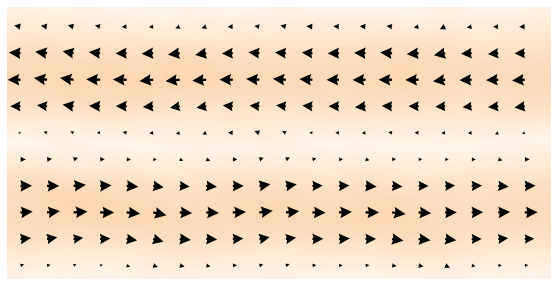

In [20]:
mean_eta, mean_hu, mean_hv = np.load("figs/mean500.npy")

Vplot(mean_eta, mean_hu, mean_hv, "figs/dj_Velo_mean.pdf")

c:\Users\florianb\Miniconda3\envs\gpuocean_opendrift\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


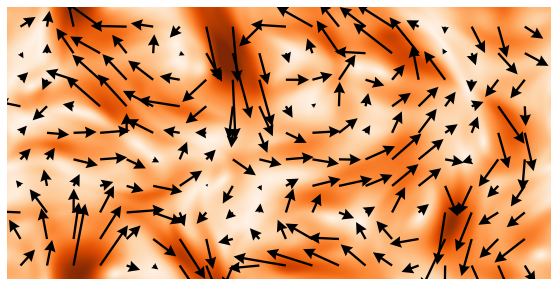

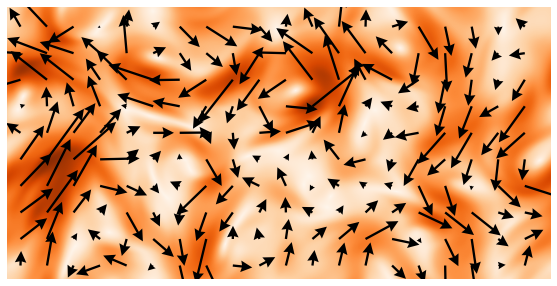

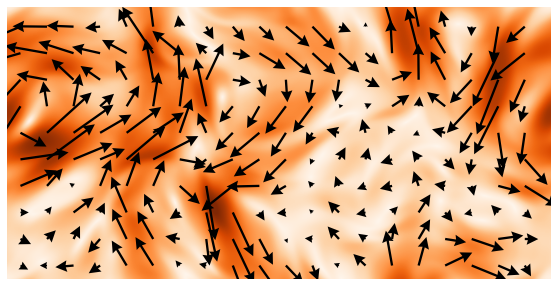

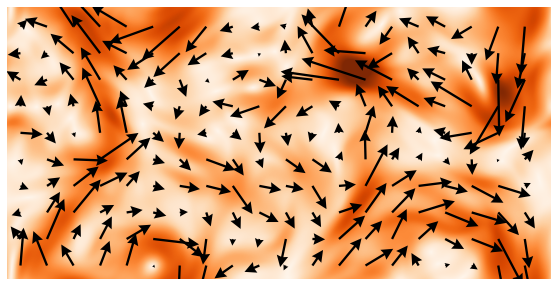

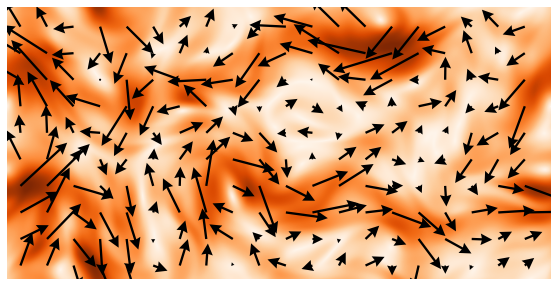

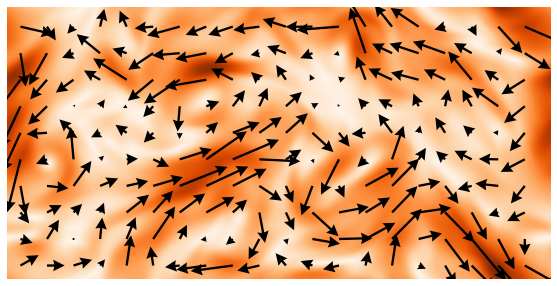

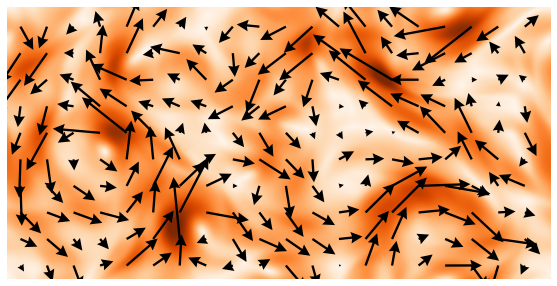

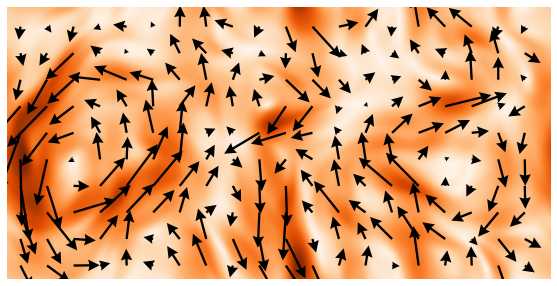

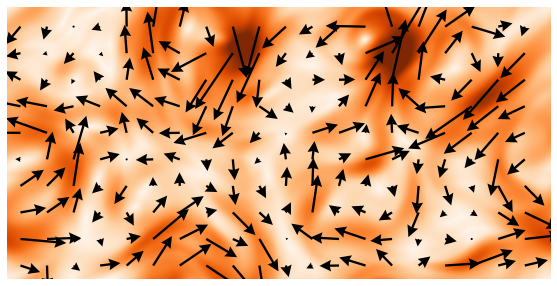

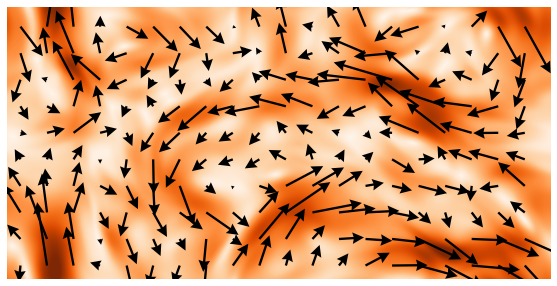

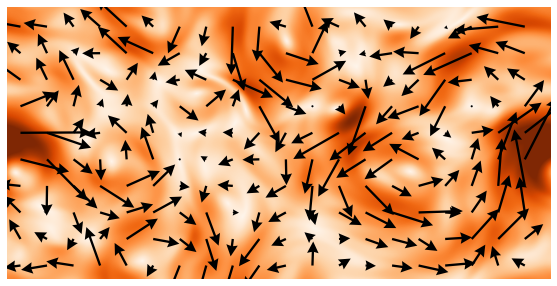

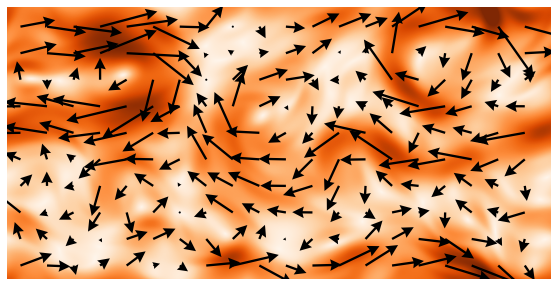

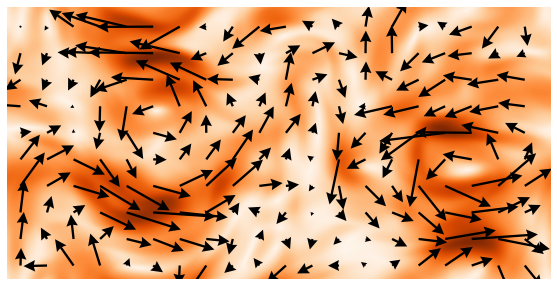

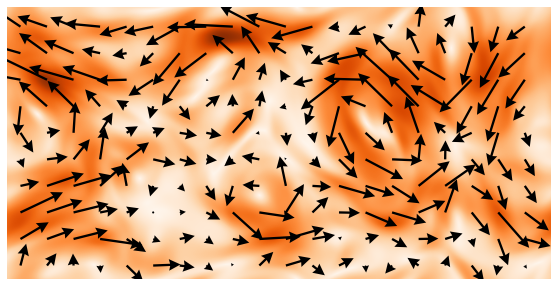

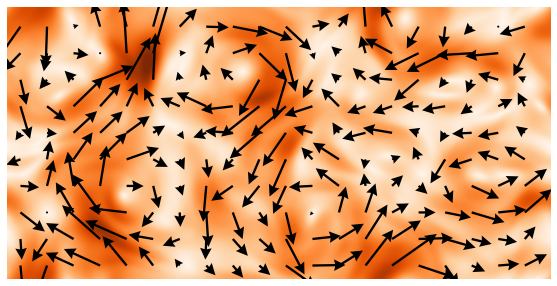

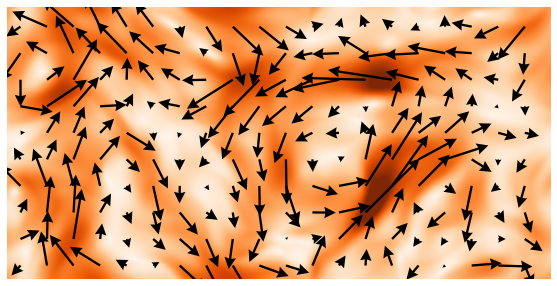

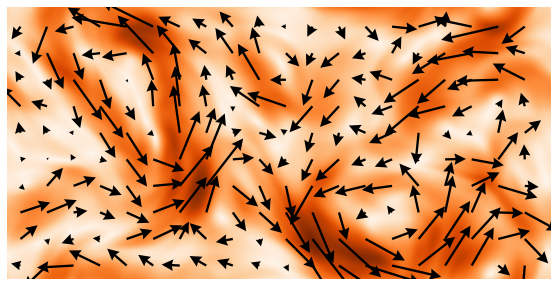

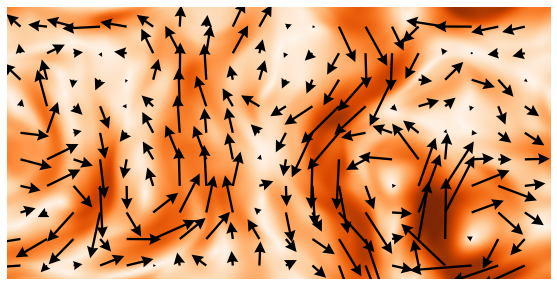

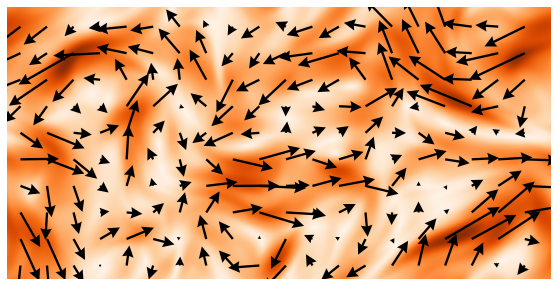

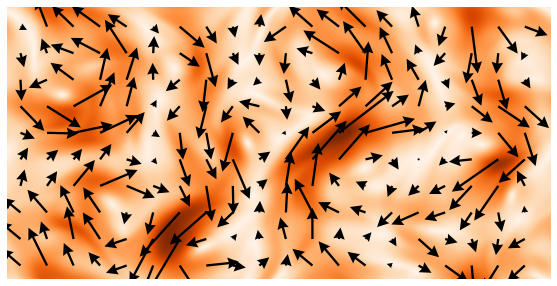

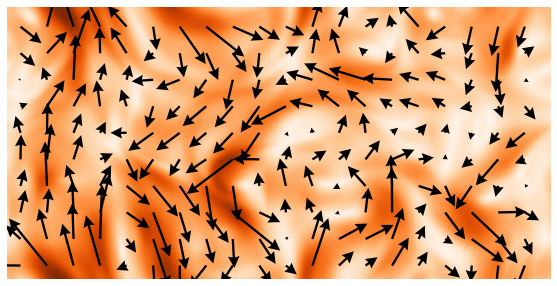

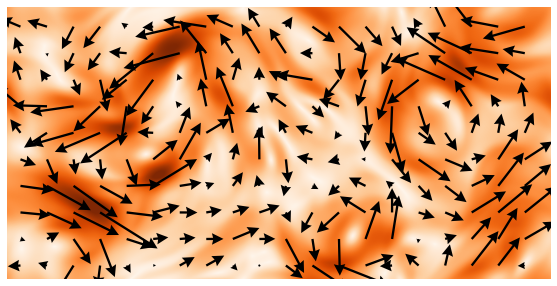

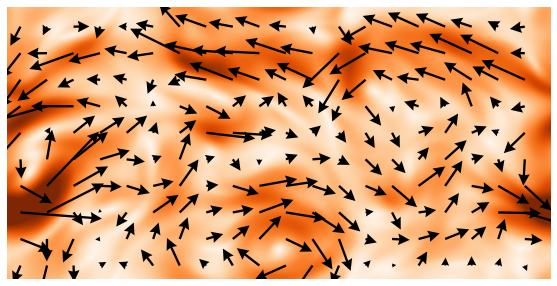

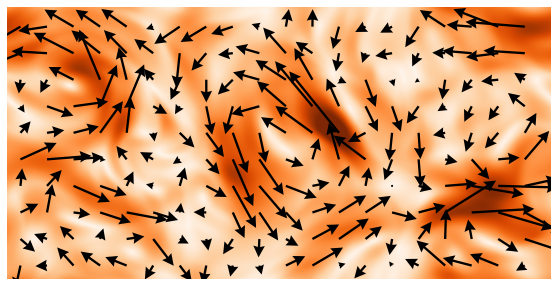

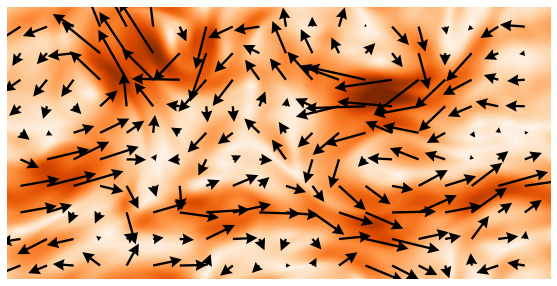

In [21]:
for e in range(ensemble.numParticles):
    eta, hu, hv = ensemble.particles[e].download(interior_domain_only=True)
    Vplot(eta, hu, hv, "figs/dj_Velo_"+str(e)+".pdf")

In [22]:
# def v_plot(eta, hu, hv, filename):

#     plt.figure(figsize=(10,5))
#     v = hv/(H + eta)

#     extent = [0, doubleJetCase_args["dx"]*doubleJetCase_args["nx"]/1000, 0, doubleJetCase_args["dy"]*doubleJetCase_args["ny"]/1000]

#     plt.imshow(v, extent=extent, cmap=plt.cm.coolwarm, vmin=-5, vmax=5)

#     plt.axis("off")
#     plt.xticks([])
#     plt.yticks([])

#     plt.savefig(filename, dpi=600, bbox_inches="tight", pad_inches=0.0)

# v_plot(mean_eta, mean_hu, mean_hv, "figs/dj_v_mean.pdf")

# for n in range(10):
#     eta, hu, hv = ensemble.particles[n].download(interior_domain_only=True)

#     v_plot(eta, hu, hv, "figs/dj_v_"+str(n)+".pdf")

In [23]:
np.random.seed(0)
ensemble.attachDrifters(np.random.uniform((0, 0), (dim_x, dim_y), (100, 2)))

In [24]:
ensemble_obs = stepToObservation(ensemble, 10*24*3600)

Step done for particle 0
Step done for particle 1
Step done for particle 2
Step done for particle 3
Step done for particle 4
Step done for particle 5
Step done for particle 6
Step done for particle 7
Step done for particle 8
Step done for particle 9
Step done for particle 10
Step done for particle 11
Step done for particle 12
Step done for particle 13
Step done for particle 14
Step done for particle 15
Step done for particle 16
Step done for particle 17
Step done for particle 18
Step done for particle 19
Step done for particle 20
Step done for particle 21
Step done for particle 22
Step done for particle 23
Step done for particle 24


In [25]:
ensemble.dumpDrifterForecastToFiles()

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "c:\Users\florianb\Miniconda3\envs\gpuocean_opendrift\lib\site-packages\IPython\core\interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\florianb\AppData\Local\Temp\ipykernel_4296\2642557915.py", line 1, in <module>
    ensemble.dumpDrifterForecastToFiles()
TypeError: dumpDrifterForecastToFiles() missing 1 required positional argument: 'filename_prefix'


TypeError: dumpDrifterForecastToFiles() missing 1 required positional argument: 'filename_prefix'

In [ ]:
from importlib import reload
from gpuocean.utils import DrifterPlotHelper
reload(DrifterPlotHelper)

<module 'gpuocean.utils.DrifterPlotHelper' from 'C:\\Users\\florianb\\Documents\\havvarsel\\gpuocean\\src\\gpuocean\\utils\\DrifterPlotHelper.py'>

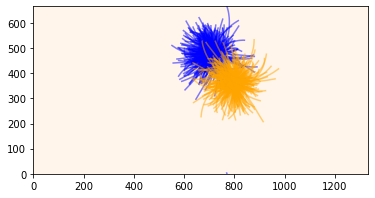

In [ ]:
ax = DrifterPlotHelper.background_from_ensemble(ensemble)

end_t=604800+12*3600

DrifterPlotHelper.add_ensemble_drifter_on_background(ax, ensemble_obs, alpha=0.5, end_t=end_t)
DrifterPlotHelper.add_ensemble_drifter_on_background(ax, ensemble_obs, drifter_id=1,alpha=0.5, color="Orange", end_t=end_t)

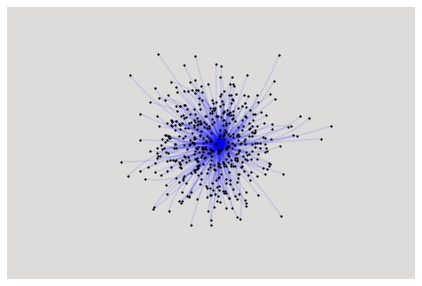

In [ ]:
drifter_id = 1

start_t = 604800
end_t = start_t + 6*3600


fig, ax = plt.subplots(figsize=(10,5))
ax.imshow(np.zeros_like(mean_eta), extent=extent, cmap=plt.cm.coolwarm, vmin=-1, vmax=1)
ax.axis("off")
ax.set_xticks([])
ax.set_yticks([])

drifter_domain = [230, 380, 90, 190]
DrifterPlotHelper.set_drifter_zoom(ax, extent, drifter_domain, doubleJetCase_args["dx"], doubleJetCase_args["dy"])


for obs in ensemble_obs:
    paths = obs.get_drifter_path(drifter_id=drifter_id, start_t=start_t, end_t=end_t, in_km=True)
    
    for path in paths:
        plt.plot(path[:,0], path[:,1], c="blue", alpha=0.1)

for obs in ensemble_obs:
    paths = obs.get_drifter_path(drifter_id=drifter_id, start_t=start_t, end_t=end_t, in_km=True)
    plt.plot(paths[-1][-1,0], paths[-1][-1,1], c="black", marker=".", markersize=2.5)

plt.savefig("figs/trajectores_"+str(drifter_id)+".pdf", dpi=600, bbox_inches="tight")

In [ ]:
from importlib import reload
reload(DrifterPlotHelper)

<module 'gpuocean.utils.DrifterPlotHelper' from 'C:\\Users\\florianb\\Documents\\havvarsel\\gpuocean\\src\\gpuocean\\utils\\DrifterPlotHelper.py'>

In [ ]:
plt.rcParams['text.usetex'] = False

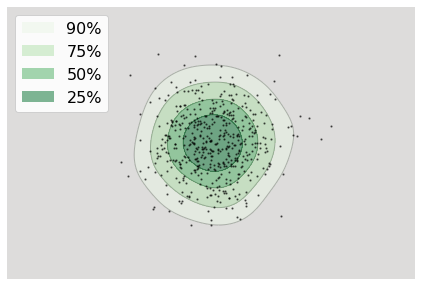

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.imshow(np.zeros_like(mean_eta), extent=extent, cmap=plt.cm.coolwarm, vmin=-1, vmax=1)
ax.axis("off")
ax.set_xticks([])
ax.set_yticks([])

drifter_domain = [230, 380, 90, 190]
DrifterPlotHelper.set_drifter_zoom(ax, extent, drifter_domain, doubleJetCase_args["dx"], doubleJetCase_args["dy"])

DrifterPlotHelper.add_kde_on_background(ax, ensemble_obs, drifter_id=drifter_id, cmap="Greens", drifter_t=end_t)

for obs in ensemble_obs:
    paths = obs.get_drifter_path(drifter_id=drifter_id, start_t=start_t, end_t=end_t, in_km=True)
    plt.plot(paths[-1][-1,0], paths[-1][-1,1], c="black", marker=".", markersize=2.5, alpha=0.5)

plt.savefig("figs/kde_"+str(drifter_id)+".pdf", dpi=600, bbox_inches="tight")